# Advanced Usage - PBMC + IFNb in sample scenario

In [1]:
### depending on which directory you run your notebook from
### you could locate pyroma package like this

import sys
#sys.path.append('/path/to/your/directory/pyroma/')
sys.path.append('/home/az/Projects/01_Curie/05_pyROMA/pyroma/')

import os
import zipfile
import io
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.io
from glob import glob

import pyroma
roma = pyroma.ROMA()
roma

scROMA

In [2]:
print(os.getcwd())
os.chdir('/home/az/Projects/01_Curie/05_pyROMA/pyroma')

/home/az/Projects/01_Curie/05_pyROMA/pyroma/docs/source/tutorials


In [3]:
datasets_dir = "/home/az/Projects/01_Curie/10_appa"

adata = sc.read_h5ad(os.path.join(datasets_dir, "kang_tutorial.h5ad"))
adata


AnnData object with n_obs × n_vars = 13576 × 14053
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type'

subsmaple to reduce the computation cost

In [4]:
sc.pp.subsample(adata, n_obs=5000)

### standard preprocessing

In [5]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [6]:
adata

AnnData object with n_obs × n_vars = 5000 × 12880
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'n_genes'
    var: 'n_cells'
    uns: 'log1p'

### first look at the data

In [7]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

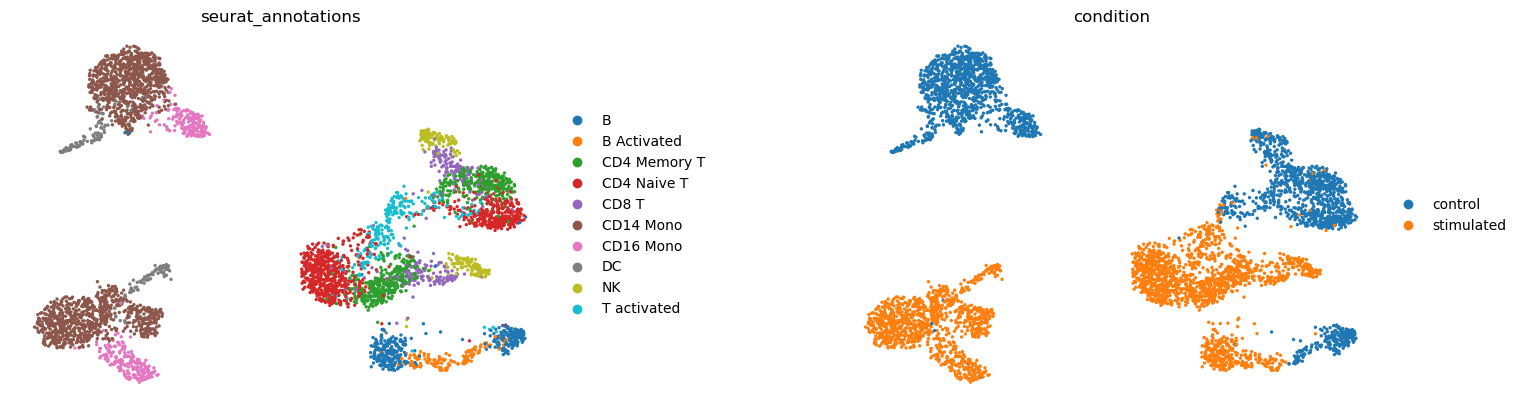

In [8]:
# seurat_annotations contain cell type information
# condition - is the IFNb stimulation category

sc.pl.umap(adata, color=['seurat_annotations', 'condition'],
           ncols=2,
           frameon=False,
           wspace=0.4)


### run pyroma

In [ ]:
import time

genesets_dir = "genesets"
output_dir = "/home/az/Projects/01_Curie/05_pyROMA/tutorial-test/02_pbmc_ifnb_sample/"
sample_name = "kang_sample_all"
roma.gmt =os.path.join(genesets_dir, "h.all.v2023.1.Hs.symbols.gmt")

roma.adata = adata
roma.pc_sign_mode = 'UseMeanExpressionAllWeights'
pathways_to_check = 'all' 

iters = 4

start = time.time()
roma.compute(pathways_to_check, 
             parallel=True,
             loocv_on=True,
             iters=iters,
            )

end = time.time()

minutes, seconds = divmod(end - start, 60)
print(f"CPU Parallel {iters} iterations for shape {adata.shape}, running time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))


Processing gene set: HALLMARK_NOTCH_SIGNALING | len of subsetlist: 27 
Processing gene set: HALLMARK_HEDGEHOG_SIGNALING | len of subsetlist: 18 
Processing gene set: HALLMARK_ANGIOGENESIS | len of subsetlist: 20 
Processing gene set: HALLMARK_PANCREAS_BETA_CELLS | len of subsetlist: 14 
Processing gene set: HALLMARK_WNT_BETA_CATENIN_SIGNALING | len of subsetlist: 34 
Processing gene set: HALLMARK_APICAL_SURFACE | len of subsetlist: 24 
Processing gene set: HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY | len of subsetlist: 46 
Processing gene set: HALLMARK_TGF_BETA_SIGNALING | len of subsetlist: 49 
Processing gene set: HALLMARK_MYC_TARGETS_V2 | len of subsetlist: 56 
Processing gene set: HALLMARK_CHOLESTEROL_HOMEOSTASIS | len of subsetlist: 63 
Processing gene set: HALLMARK_IL6_JAK_STAT3_SIGNALING | len of subsetlist: 75 
Processing gene set: HALLMARK_PROTEIN_SECRETION | len of subsetlist: 88 
Processing gene set: HALLMARK_INTERFERON_ALPHA_RESPONSE | len of subsetlist: 93 
Processing gene s

In [10]:
roma

scROMA: module activities are computed

In [11]:
roma.adata

AnnData object with n_obs × n_vars = 5000 × 12880
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'n_genes'
    var: 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'seurat_annotations_colors', 'condition_colors', 'ROMA_stats', 'ROMA_active_modules'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### all the pyroma statistics

In [12]:
roma.adata.uns['ROMA_stats']

,L1,ppv L1,Median Exp,ppv Med Exp,q L1,q Med Exp
HALLMARK_NOTCH_SIGNALING,0.384652,0.25,-0.050278,0.2,0.543478,0.294118
HALLMARK_HEDGEHOG_SIGNALING,0.255147,0.50,0.032030,0.4,0.757576,0.526316
HALLMARK_ANGIOGENESIS,0.794333,0.00,0.211960,0.2,0.000000,0.294118
HALLMARK_PANCREAS_BETA_CELLS,0.304289,0.50,0.050902,0.2,0.757576,0.294118
HALLMARK_WNT_BETA_CATENIN_SIGNALING,0.271194,0.50,0.065561,0.2,0.757576,0.294118
HALLMARK_APICAL_SURFACE,0.364107,0.25,0.016599,0.6,0.543478,0.750000
HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,0.547606,0.00,0.129238,0.2,0.000000,0.294118
HALLMARK_TGF_BETA_SIGNALING,0.152931,1.00,0.051522,0.2,1.000000,0.294118
HALLMARK_MYC_TARGETS_V2,0.203941,0.75,0.840067,0.2,1.000000,0.294118
HALLMARK_CHOLESTEROL_HOMEOSTASIS,0.413750,0.25,0.062514,0.2,0.543478,0.294118


### active pathways

In [13]:
roma.adata.uns['ROMA_active_modules'].sort_values(by='Median Exp')

,L1,ppv L1,Median Exp,ppv Med Exp,q L1,q Med Exp
HALLMARK_ALLOGRAFT_REJECTION,0.289093,0.0,-0.087632,0.2,0.0,0.294118
HALLMARK_KRAS_SIGNALING_UP,0.347654,0.0,-0.084910,0.2,0.0,0.294118
HALLMARK_P53_PATHWAY,0.272462,0.0,-0.040656,0.4,0.0,0.526316
HALLMARK_ESTROGEN_RESPONSE_LATE,0.247038,0.0,-0.020742,1.0,0.0,1.000000
HALLMARK_KRAS_SIGNALING_DN,0.513634,0.0,-0.014920,1.0,0.0,1.000000
HALLMARK_IL2_STAT5_SIGNALING,0.360993,0.0,0.024553,0.8,0.0,0.952381
HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,0.547606,0.0,0.129238,0.2,0.0,0.294118
HALLMARK_APOPTOSIS,0.279904,0.0,0.130335,0.2,0.0,0.294118
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,0.438296,0.0,0.136218,0.2,0.0,0.294118
HALLMARK_ANGIOGENESIS,0.794333,0.0,0.211960,0.2,0.0,0.294118


In [15]:
roma.summary()


=== ROMA Analysis Summary ===

Total gene sets analyzed: 50
Active modules (overdispersed): 15
Active modules (shifted): 0

Top 5 overdispersed modules:
  HALLMARK_ANGIOGENESIS: L1=0.794, q=0.000e+00
  HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY: L1=0.548, q=0.000e+00
  HALLMARK_COAGULATION: L1=0.454, q=0.000e+00
  HALLMARK_APOPTOSIS: L1=0.280, q=0.000e+00
  HALLMARK_IL2_STAT5_SIGNALING: L1=0.361, q=0.000e+00

Top 5 shifted modules:
  HALLMARK_NOTCH_SIGNALING: Med=-0.050, q=2.941e-01
  HALLMARK_ANGIOGENESIS: Med=0.212, q=2.941e-01
  HALLMARK_PANCREAS_BETA_CELLS: Med=0.051, q=2.941e-01
  HALLMARK_WNT_BETA_CATENIN_SIGNALING: Med=0.066, q=2.941e-01
  HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY: Med=0.129, q=2.941e-01

Potential issues found: 1
  missing_genes: 1 modules


### visualize results

In [17]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(6, 6))
save_dir=os.path.join(output_dir,sample_name,'01_figures')
os.makedirs(save_dir, exist_ok=True)
sc.settings.figdir = save_dir

In [20]:
active_pathways

['HALLMARK_ANGIOGENESIS',
 'HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY',
 'HALLMARK_COAGULATION',
 'HALLMARK_APOPTOSIS',
 'HALLMARK_IL2_STAT5_SIGNALING',
 'HALLMARK_TNFA_SIGNALING_VIA_NFKB',
 'HALLMARK_ESTROGEN_RESPONSE_LATE',
 'HALLMARK_INTERFERON_GAMMA_RESPONSE',
 'HALLMARK_COMPLEMENT',
 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION',
 'HALLMARK_INFLAMMATORY_RESPONSE',
 'HALLMARK_P53_PATHWAY',
 'HALLMARK_ALLOGRAFT_REJECTION',
 'HALLMARK_KRAS_SIGNALING_UP',
 'HALLMARK_KRAS_SIGNALING_DN']

In [24]:
roma.load_active_modules_results(path=os.path.join(output_dir,sample_name))   


In [25]:
adata

AnnData object with n_obs × n_vars = 5000 × 12880
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'n_genes'
    var: 'n_cells'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'seurat_annotations_colors', 'condition_colors', 'ROMA_stats', 'ROMA_active_modules', 'ROMA'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [26]:
roma.load_active_modules_results(path=os.path.join(output_dir,sample_name))   

active_pathways = roma.adata.uns['ROMA_active_modules'].index.tolist()

df = pd.DataFrame(index=adata.obs.index)
for k in active_pathways:
    v = adata.uns['ROMA_stats'][k]
    df[k] = v.svd.components_[0]

adata.obsm['pyroma_scores'] = df.copy()
adata

KeyError: 'HALLMARK_ANGIOGENESIS'

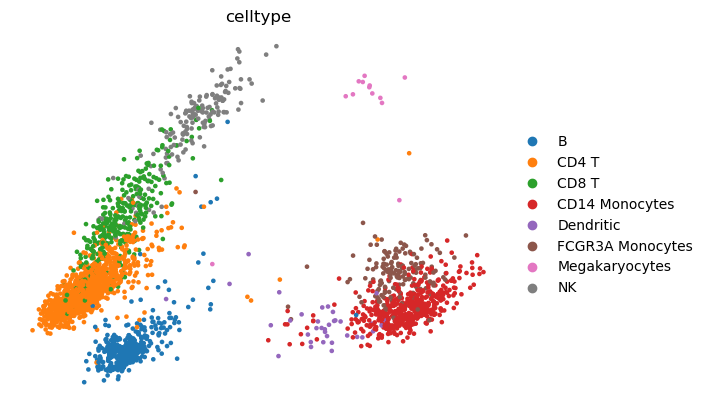

In [ ]:
sc.pl.pca(adata, color=['celltype',
                                ],
                                frameon=False,
                                ncols=2,
                                wspace=0.4)

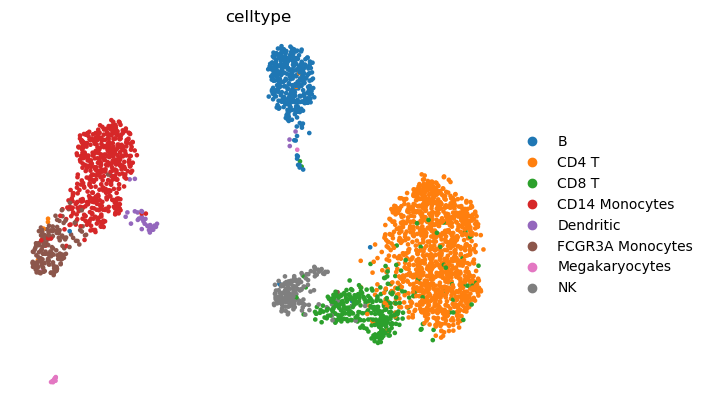

In [ ]:
sc.pl.umap(adata, color=['celltype',
                                ],
                                frameon=False,
                                ncols=2,
                                wspace=0.4)

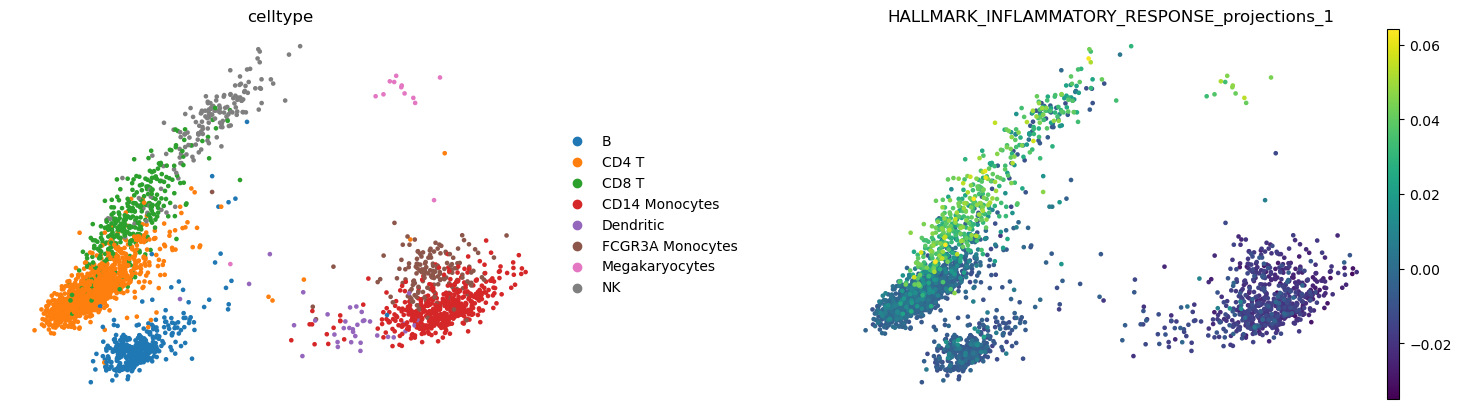

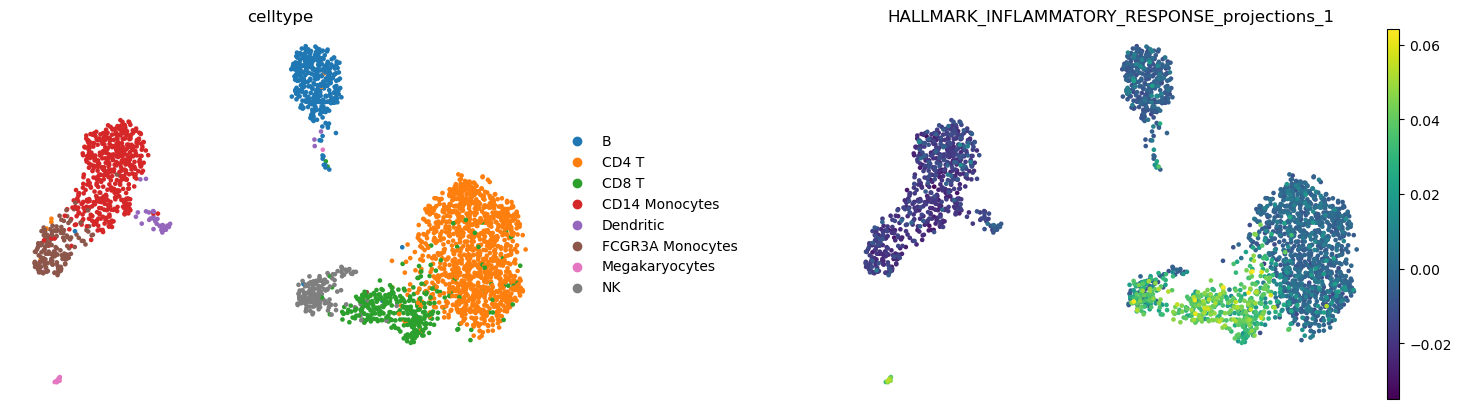

In [ ]:
geneset_name = 'HALLMARK_INFLAMMATORY_RESPONSE'

roma.adata.obs[f'{geneset_name}_projections_1'] = roma.adata.uns['ROMA'][f'{geneset_name}'].svd.components_[0]
roma.adata.obs[f'{geneset_name}_projections_1_reverse'] = -1 * roma.adata.uns['ROMA'][f'{geneset_name}'].svd.components_[0]

GeneScores = pd.DataFrame(roma.adata.uns['ROMA'][f'{geneset_name}'].projections_1,
                index=roma.adata.uns['ROMA'][f'{geneset_name}'].subsetlist,
                columns=[f'{geneset_name}'])

sc.pl.pca(adata, color=['celltype',
                                f'{geneset_name}_projections_1'],
                                frameon=False,
                                ncols=2,
                                wspace=0.4)

sc.pl.umap(adata, color=['celltype',
                                f'{geneset_name}_projections_1'],
                                frameon=False,
                                ncols=2,
                                wspace=0.4)

In [ ]:
GeneScores

,HALLMARK_INFLAMMATORY_RESPONSE
CXCL10,0.170369
CCL2,0.171709
CCL5,-45.372200
FPR1,3.666031
CCL20,-0.093299
...,...
STAB1,0.306723
IRF1,-1.357291
ICAM4,0.329865
P2RX4,0.153793


In [ ]:
# optional: to load pathway-genes dictionary 
genesets = roma.read_gmt_to_dict(roma.gmt)


### save and load results

In [ ]:
save_dir=os.path.join(output_dir, sample_name)

roma.save_active_modules_results(
                                path=save_dir,
                                only_active=False
                                 )


In [ ]:
del roma.adata

In [ ]:
#roma.adata

In [ ]:
load_dir = 'results'

roma.load_active_modules_results(path=save_dir)   

AttributeError: 'ROMA' object has no attribute 'adata'

In [ ]:
roma.adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'celltype', 'n_genes', 'HALLMARK_INFLAMMATORY_RESPONSE_projections_1', 'HALLMARK_INFLAMMATORY_RESPONSE_projections_1_reverse'
    var: 'gene_ids', 'n_cells'
    uns: 'ROMA_active_modules', 'ROMA_stats', 'celltype_colors', 'log1p', 'neighbors', 'pca', 'umap', 'ROMA'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### top contributing genes

In [ ]:
GeneScores.sort_values(by=geneset_name)

,HALLMARK_INFLAMMATORY_RESPONSE
LY6E,-9.469896
TIMP1,-8.930674
CD14,-7.395456
NFKBIA,-5.897358
RHOG,-4.730138
...,...
CD69,3.288985
IL7R,6.165412
IFITM1,6.817437
LCK,8.328794


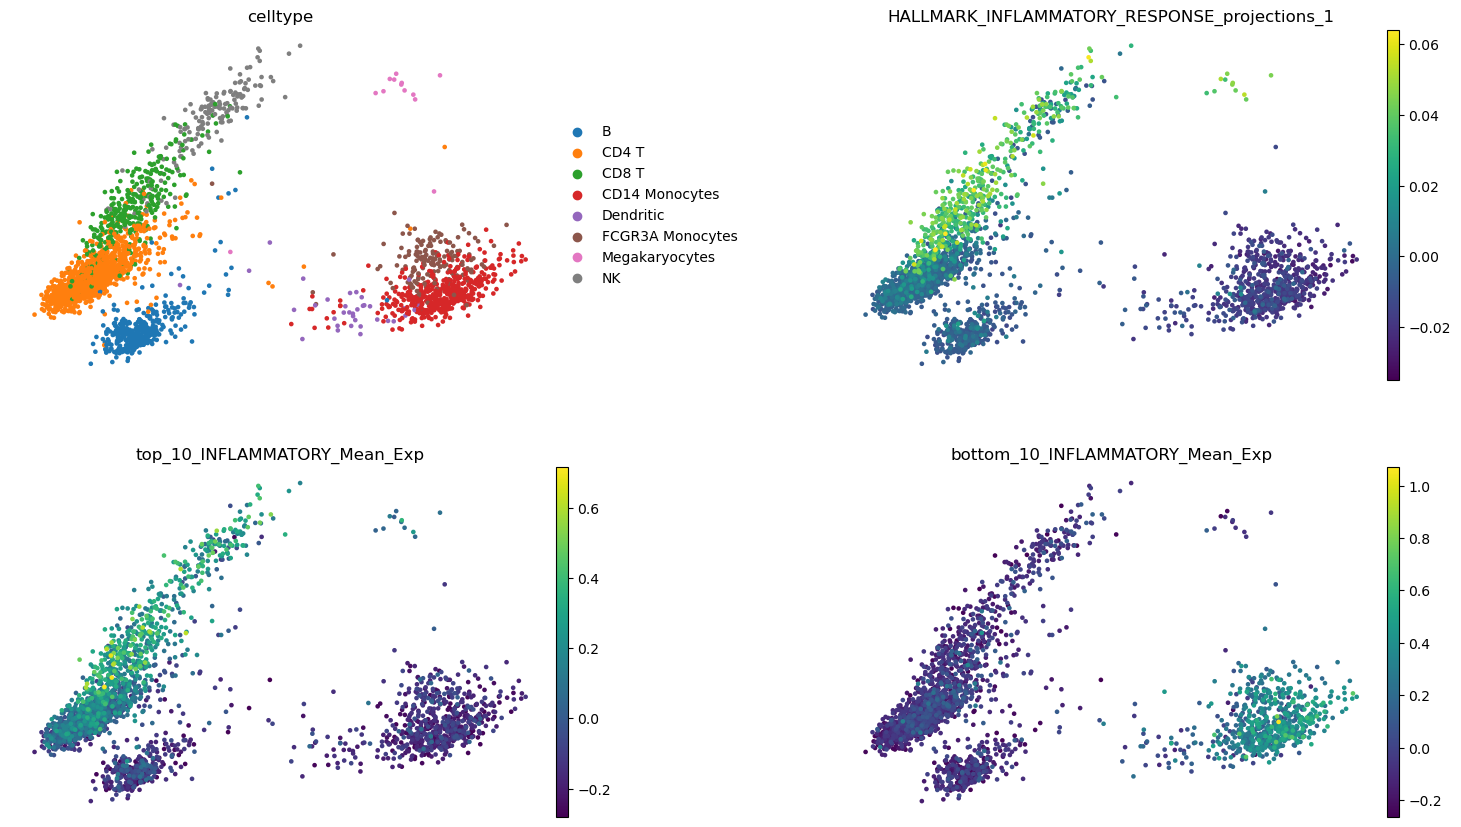

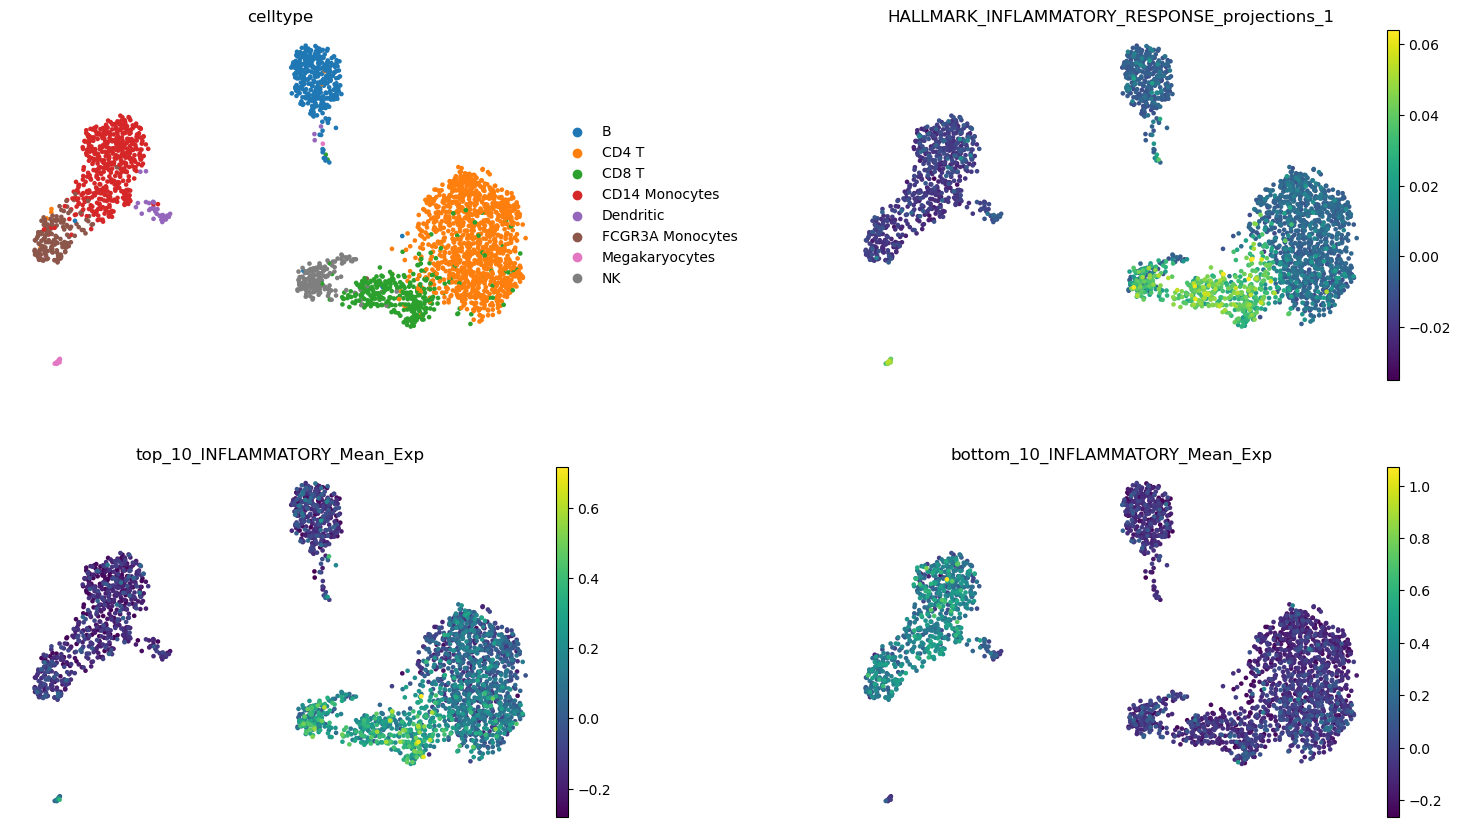

In [ ]:
# number of top and bottom genes
n_top = 10
short_name = geneset_name.split('_')[1]

top_n = GeneScores.sort_values(by=f'{geneset_name}', ascending=False).head(n_top).index.tolist()
bottom_n = GeneScores.sort_values(by=f'{geneset_name}', ascending=False).tail(n_top).index.tolist()

top_mean_exp = roma.adata[:, top_n].X.mean(axis=1)
bottom_mean_exp = roma.adata[:, bottom_n].X.mean(axis=1)

roma.adata.obs[f'top_{n_top}_{short_name}_Mean_Exp'] = top_mean_exp
roma.adata.obs[f'bottom_{n_top}_{short_name}_Mean_Exp'] = bottom_mean_exp

sc.pl.pca(roma.adata, color=['celltype',
                                f'{geneset_name}_projections_1',
                                f'top_{n_top}_{short_name}_Mean_Exp',
                                f'bottom_{n_top}_{short_name}_Mean_Exp'], 
                                frameon=False,
                                ncols=2,
                                wspace=0.4)

sc.pl.umap(roma.adata, color=['celltype',
                                f'{geneset_name}_projections_1',
                                f'top_{n_top}_{short_name}_Mean_Exp',
                                f'bottom_{n_top}_{short_name}_Mean_Exp'], 
                                frameon=False,
                                ncols=2,
                                wspace=0.4)


### end